In [1]:
#Notebook to retrieve the dataset of the noisy

In [37]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from astropy.stats import mad_std

#from sfh.datasets.mergers import tng100_images

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
#train_dset,test_dset = tfds.load('tng100_images', split=['train[:75%]','train[75%:]'])
train_dset,valid_dset,test_dset = tfds.load('tng100_images', split=['train[:75%]','train[75%:85%]','train[85%:]'])

2021-12-08 10:18:04.891044: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfslocalsup/spack_soft/openmpi/4.1.1/gcc-8.3.1-buyiit4vlnfnuq6vgvlsmlkgexrh6myv/lib:/gpfslocalsup/spack_soft/cudnn/8.1.1.33-11.2/gcc-8.3.1-dgsfwc7e23vzc36jopc5nxyunptm2ieh/lib64:/gpfslocalsup/spack_soft/nccl/2.8.3-1/gcc-8.3.1-ov5kn3zvtxssh6cpr4gk5sgae5vkhgco/lib:/gpfslocalsys/cuda/11.2/nvvm/lib64:/gpfslocalsys/cuda/11.2/extras/CUPTI/lib64:/gpfslocalsys/cuda/11.2/lib64:/gpfslocalsys/cuda/11.2/samples/common/lib/linux/x86_64:/gpfslocalsys/cuda/11.2/targets/x86_64-linux/lib:/gpfslocalsys/slurm/current/lib/slurm:/gpfslocalsys/slurm/current/lib
2021-12-08 10:18:04.891083: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-08 10:18:04.891109: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] ke

In [5]:
train_dset

<PrefetchDataset shapes: {image: (128, 128, 4), last_major_merger: (), object_id: ()}, types: {image: tf.float32, last_major_merger: tf.float32, object_id: tf.int32}>

In [6]:
test_dset

<PrefetchDataset shapes: {image: (128, 128, 4), last_major_merger: (), object_id: ()}, types: {image: tf.float32, last_major_merger: tf.float32, object_id: tf.int32}>

In [7]:
print("Test",len(test_dset))
print("Train",len(train_dset))
print("Train",len(valid_dset))

print("Total",len(train_dset)+len(test_dset)+len(valid_dset))

Test 1586
Train 7928
Train 1056
Total 10570


2021-12-08 10:18:45.259769: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


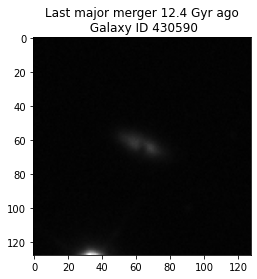

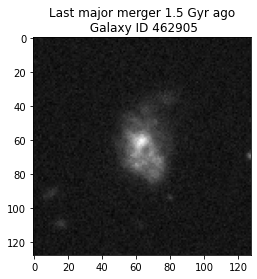

In [8]:
for example in train_dset.take(2):
    plt.figure()
    plt.imshow(example["image"][:,:,1],cmap='gray')
    lbt=float(example["last_major_merger"])
    plt.title("Last major merger "+str("{:.1f}".format(lbt))+" Gyr ago"+"\n Galaxy ID "+str(int(example["object_id"])))

In [13]:
float(example["last_major_merger"])

12.437000274658203

**Normalise images**

In [24]:
# Let's collect a few examples to check their distributions
imgs=[]
for (batch, entry) in enumerate(train_dset.take(1000)):
    imgs.append(entry['image'])
imgs=np.array(imgs)

Text(0.5, 1.0, 'Histogram of the pixel values in the first 300 images')

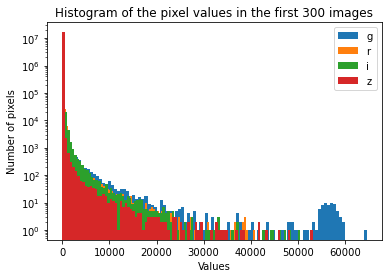

In [42]:
#Check pixel distribution for a few images
for i,b in enumerate(['g', 'r', 'i', 'z']):
    plt.hist(imgs[:,:,:,i].flatten(),100, label=b)
plt.legend()
plt.yscale("log")
plt.ylabel("Number of pixels")
plt.xlabel("Values")
plt.title("Histogram of the pixel values in the first 300 images")

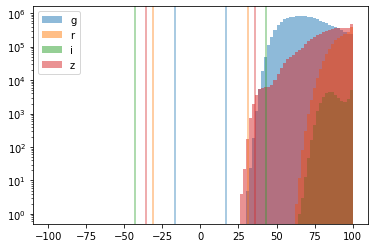

In [47]:
# Let's evaluate the noise standard deviation in each band, and apply range 
# compression accordingly
scaling = []

for i,b in enumerate(['g', 'r', 'i', 'z']):
    plt.hist(imgs[:,:,:,i].flatten(),100, label=b,alpha=0.5,range=[-100,100]);
    sigma = mad_std(imgs[:,:,:,i].flatten())
    scaling.append(sigma)
    plt.axvline(sigma, color='C%d'%i,alpha=0.5)
    plt.axvline(-sigma, color='C%d'%i,alpha=0.5)
plt.legend()
plt.yscale("log")

Text(0.5, 1.0, 'Histogram of the pixel values after rescaling by the standard deviation')

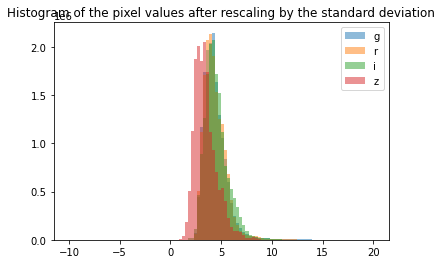

In [53]:
# Let's have a look at this distribution if we rescale each band by the standard
# deviation
for i,b in enumerate(['g', 'r', 'i', 'z']):
    plt.hist(imgs[:,:,:,i].flatten()/scaling[i],100, label=b,alpha=0.5,range=[-10,20]);
plt.legend()
plt.title("Histogram of the pixel values after rescaling by the standard deviation")


Text(0.5, 1.0, 'Histogram of the pixel values after scaling by std and arcsinh')

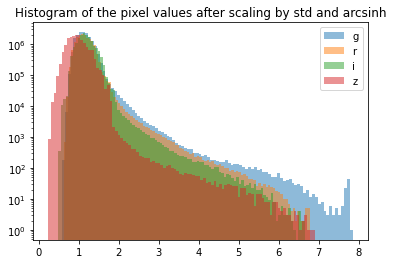

In [56]:
# a common approach for range compression is to apply arcsinh to suppress the
# high amplitude values
for i,b in enumerate(['g', 'r', 'i', 'z']):
    plt.hist(np.arcsinh(imgs[:,:,:,i].flatten()/scaling[i]/3),100,
           label=b, alpha=0.5);
plt.legend()
plt.yscale('log')
plt.title("Histogram of the pixel values after scaling by std and arcsinh")


In [82]:
# Using a mapping function to apply preprocessing to our data
def evaluate_scaling(train_dset):
    """
    Evaluates the standard deviation of the pixel values in each band g,r,i,z.
    Input: train_dset (tensforflow dataset): training datset on which we want to evaluate the scaling
    Output: scaling (np array): array containig the std in each band
    """
    #Takes 100 images from wich the std will be estimated  
    imgs=[]
    for (batch, entry) in enumerate(train_dset.take(100)):
        imgs.append(entry['image'])
    imgs=np.array(imgs)
    #Computes the scaling
    scaling = []
    for i,b in enumerate(['g', 'r', 'i', 'z']):
        sigma = mad_std(imgs[:,:,:,i].flatten())
        scaling.append(sigma)
    return scaling

def preprocessing(example):
    """
    Normalises the images from the original dataset, by dividing it by the std in each band and by appling arcsinh scaling.
    NB: scaling is a global variable, as this notebook is made only for one particular example and cannot be generalized without changing the code
    Input: example (dict): example from the tensorflow dataset
    Output: norm_img (np ndarray): normalised image
            example["last_major_merger"]: tf tensor containing the lookback time of the last major merger
            example["object_id"]: tf tensor containing the galaxy id        
    """
    img=example["image"]
    norm_img=tf.math.asinh(img/tf.constant(scaling))
    return norm_img,example["last_major_merger"],example["object_id"]

In [84]:
scaling=evaluate_scaling(train_dset)
print(scaling)

[14.680999273652667, 33.26186043453564, 52.801574038812326, 42.99546433666246]


In [85]:
#Normalise the training dataset
norm_train_dset = train_dset.map(preprocessing)

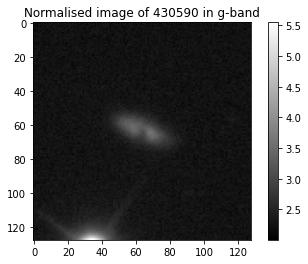

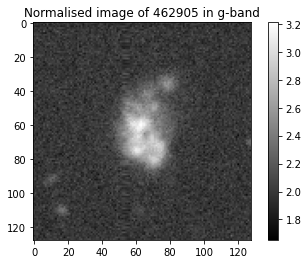

In [101]:
#Check the normalisation on a few examples
norm_imgs,last_major_merger,object_id=[],[],[]
for example in norm_train_dset.take(2):
    #print(np.shape(ex))
    plt.figure()
    norm_imgs.append(example[0])
    last_major_merger.append(float(example[1]))
    object_id.append(int(example[2]))
    plt.imshow(norm_imgs[-1][:,:,0],cmap='gray')
    plt.title("Normalised image of "+str(object_id[-1])+" in g-band")
    plt.colorbar()

**Create the input pipeline**

In [ ]:
def input_pipeline(mode='train', batch_size=64):
    """
    Creates the input pipeline that loads the dataset and normalises the data
    mode: 'train' or 'test'
    """
    if mode == 'train':
        dataset = tfds.load('hsc_photoz', split='train[:80%]')
        dataset = dataset.repeat()
        dataset = dataset.shuffle(10000)
    else:
        dataset = tfds.load('hsc_photoz', split='train[80%:]')

    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.map(preprocessing) # Apply data preprocessing
    dataset = dataset.prefetch(-1) # fetch next batches while training current one (-1 for autotune)
    return dataset